# GEONE - GEOSCLASSIC - non-stationary covariance model

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

See notebook `ex_geosclassic_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS) in a grid - using stationary covariance model.

## Non-stationary covariance model over a grid
To deal with non-stationary covariance model over a grid (local rotation, local sill, ranges, etc.):
- a stationary covariance model `cov_model` is defined (see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples)

and local rotation is handled by specifying angle(s) over the grid:
- `alpha`, `beta`, `gamma`: function (callable), or array-like of floats, or float, optional; angle(s) defining a rotation of the covariance model (see the notebook `ex_general_multiGaussian.ipynb` for explanations examples), where:
    - if a function: function of `d` argument(s) where `d` is the space dimension that returns a value for each location given by their coordinate(s) in argument
    - if array-like: its size must be equal to the number of grid cells (the array is reshaped if needed), values at grid cells
    - if a float: same value at every grid cell
    - by default (`None`): not used


and other non-stationarities are handled by specifying:
- a list `cov_model_non_stationarity_list` ; each entry must be a tuple (or list) `cm_ns` of length 2 or 3 with:
    - `cm_ns[0]`: str: the name of the method of `cov_model` to be applied
    - `cm_ns[1]`: function (callable), or array-like of floats, or float: used to set the main parameter passed to the method:
        - if a function: function of `d` argument(s) where `d` is the space dimension that returns a value for each location given by their coordinate(s) in argument
        - if array-like: its size must be equal to the number of grid cells (the array is reshaped if needed), values at grid cells
        - if a float: same value at every grid cell
    - `cm_ns[2]`: dict, optional: keyworkds arguments to be passed to the method

Examples (where the parameter `arg` is set from `val`):        
- `('multiply_w', val)` will apply `cov_model.multiply_w(arg)`; this multipies the weight contribution of every elementary contribution of the covariance model
- `('multiply_w', val, {'elem_ind':0})` will apply `cov_model.multiply_w(arg, elem_ind=0)`; this multipies the weight contribution of the elementary contribution of index 0 of the covariance model
- `('multiply_r', val)` will apply `cov_model.multiply_r(arg)`; this multipies the range in all direction of every elementary contribution of the covariance model
- `('multiply_r', val, {'r_ind':0})` will apply `cov_model.multiply_r(arg, r_ind=0)`; this multipies the range in the first main direction (index 0) of every elementary contribution of the covariance model
- `('multiply_r', val, {'r_ind':0, 'elem_ind':0})` will apply `cov_model.multiply_r(arg, r_ind=0, elem_ind=0)`; this multipies the range in the first main direction (index 0) of the elementary contribution of index 0 of the covariance model

*Note: unique search neighorhood can not be used with a non-stationary covariance model.*

## Examples in 1D
In this notebook, examples in 1D with a non-stationary covariance model are given.


## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Grid (1D)

In [3]:
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin

## Covariance model

In 1D, a covariance model is given by an instance of the class `geone.covModel.covModel1D`.

### Base covariance model (sationary)
The weight `'w'` to every elementary contribution is set to `1.0`; the method `multiply_w` will be used to set non-stationarities about this parameter.

In [4]:
# Define the base covariance model (stationary)
cov_model = gn.covModel.CovModel1D(elem=[
    ('gaussian', {'w':1.0, 'r':100}),  # elementary contribution
    ('nugget', {'w':1.0}),             # elementary contribution
    ], name='model-1D example')


In [5]:
# plt.figure()
# cov_model.plot_model()
# plt.title('Covariance function - base')
# plt.show()

### Defining non-stationarities


In [6]:
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, 1, 1, sx, 1.0, 1.0, ox, 0.0, 0.0, nv=0)

# Get the x coordinates of the centers of grid cell
x_grid = im.x()

# Set weight over the grid for the elementary contributions of the covariance model (array)
nug_w = 9. * 1. / (1. + np.exp(-(x_grid-350)/20)) # for nugget
gau_w = 9 - nug_w                                 # for gaussian covariance contribution

# Set list to handle non-stationarities for further estimation/simulation in the grid
cov_model_non_stationarity_list = [
    ('multiply_w', gau_w, {'elem_ind':0}), # multiply weight by `gau_w` for elem. contrib. of index 0
    ('multiply_w', nug_w, {'elem_ind':1}), # multiply weight by `nug_w` for elem. contrib. of index 1
]
# Note: `gau_w`, `nug_w` could also be a function of one parameter (x location)

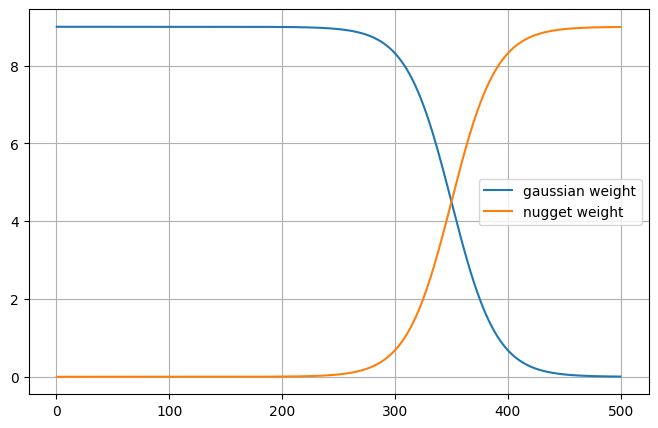

In [7]:
# Plot non-stationarities
plt.figure(figsize=(8,5))
plt.plot(x_grid, gau_w, label='gaussian weight')
plt.plot(x_grid, nug_w, label='nugget weight')
plt.grid()
plt.legend()
plt.show()

## Set-up (for estimation and simulation)

In [8]:
# Data
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                 #     float: same for all data points
                                 #     list or array: per data point

# Inequality data
x_ineq = [100.32, 185.75, 288.57] # locations (real coordinates)
v_ineq_min = [  np.nan,    1.2 ,  -2.9]  # lower bounds
v_ineq_max = [    -0.7, np.nan,   -1.4]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Type of kriging
method = 'simple_kriging'

# Non-stationarities for covariance model: see `cov_model_non_stationarity_list` above

### Estimation (kriging)

In [9]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             # 
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.56 sec


### Simulations

In [10]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (2000 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 999...
_ru

### Plot the results

In [11]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


In [12]:
# Extract coordinates along x-axis (cell centers)
xc = krig_img.x() 
# xc = simul_img.x() # equiv.

# Extract kriging estimates and std
krig_est = krig_img.val[0, 0, 0, :]
krig_std = krig_img.val[1, 0, 0, :]

# Extract simulations
simul = simul_img.val[:, 0, 0, :] # all simulations, simul[i] : realization of index i
simul_mean = simul_img_mean.val[0, 0, 0, :] # or: simul_mean = np.mean(simul, axis=0)
simul_std  = simul_img_std.val [0, 0, 0, :] # or: simul_std = np.std(simul, axis=0)
simul_min  = simul_img_min.val [0, 0, 0, :] # or: simul_min = np.min(simul, axis=0)
simul_max  = simul_img_max.val [0, 0, 0, :] # or: simul_max = np.max(simul, axis=0)
simul_q    = simul_img_q.val   [:, 0, 0, :] # or: simul_q = np.quantile(simul, q=q, axis=0)


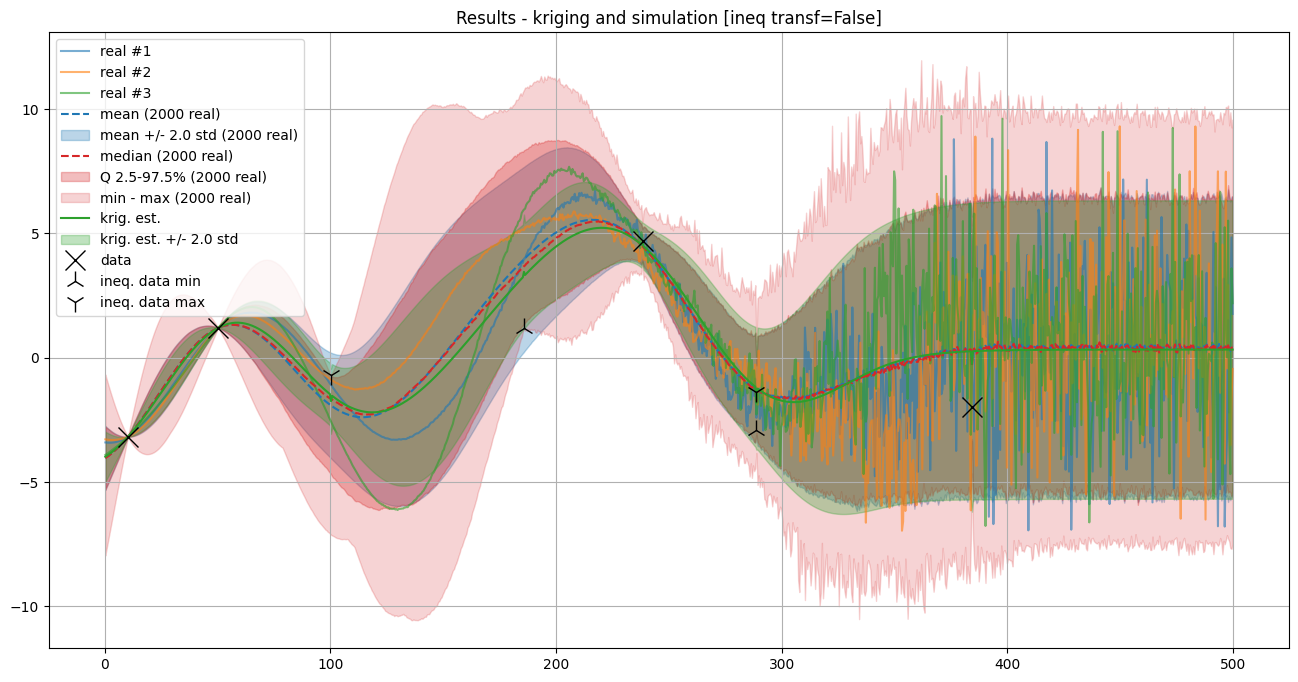

In [13]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- t std
col_sim_mean = 'tab:blue'
plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xc, 
                 simul_mean - t * simul_std, 
                 simul_mean + t * simul_std,
                 color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='solid', label=f'krig. est.')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data
if x_ineq is not None:
    plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')

plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [14]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]
    # Distance to center cell
    dist_to_x_center = np.abs(np.asarray(x) - np.asarray(x_center))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                          = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.15
   data value                          = -3.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.184e+00 [krig. std = 6.509e-03]
   simul. [ineq transf=False]   : mean = -3.184e+00, min = -3.197e+00, max = -3.166e+00 [std = 4.463e-03]
Data point index 1, dist. to cell center = 0
   data value                          = 1.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.200e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 4.661e-16]
Data point index 2, dist. to cell center = 0.25
   data value                          = 4.700e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.635e+00 [krig. std = 3.934e-01]
   simul. [ineq transf=False]   : mean = 4.535e+00, min = 3.864e+00, max = 5.434e+00 [std = 3.152e-01]
Data point index 3, dist. to cell center = 0.05
   data value                   

In [15]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]
    # Distance to center cell
    dist_to_x_ineq_center = np.abs(np.asarray(x_ineq) - np.asarray(x_ineq_center))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.07
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 99.650%
Ineq. data point index 1, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
Ineq. data point index 2, dist. to cell center = 0.18
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 96.200%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 68.500%
